In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout,Flatten
from tensorflow.keras import initializers
from tensorflow.keras.layers import GRU

In [3]:
data = pd.read_csv('/content/finaldataset_normalized.csv', header=0, infer_datetime_format=True)

In [4]:
n_steps=10

input_cols = data.columns
input_cols=input_cols.delete(0)
input_cols=input_cols.delete(8)

In [6]:
output_cols = ['maxtemp']

In [7]:
# Create the training and testing datasets
train_data = data.loc[data['datetime']<='2014-12-31']
test_data = data.loc[data['datetime']>='2015-01-01']

In [8]:
def to_sequences(data, n_steps, input_cols, output_cols):
    X, y = [], []
    for i in range(len(data)-n_steps):
        x = data[input_cols].values[i:i+n_steps]
        X.append(x)
        for col in output_cols:
            y.append(data[col].values[i+n_steps])
    return np.array(X), np.array(y)

In [9]:
train_X, train_y = to_sequences(train_data, n_steps, input_cols, output_cols)
test_X, test_y = to_sequences(test_data, n_steps, input_cols, output_cols)

In [11]:
initializer = initializers.GlorotUniform()

In [12]:
# Define the model architecture
model = Sequential()
model.add(Conv1D(filters=224, kernel_size=1, strides=1, activation='relu', kernel_initializer=initializer, input_shape=(n_steps, len(input_cols))))
model.add(Conv1D(filters=192, kernel_size=1, strides=1, activation='relu', kernel_initializer=initializer))
model.add(Dropout(0.3))

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [13]:
# Gated Recurrent Unit (GRU) layers
model.add(GRU(64, activation='relu', kernel_initializer=initializer, return_sequences=True))
model.add(GRU(64, activation='relu', kernel_initializer=initializer, return_sequences=True))
model.add(GRU(64, activation='relu', kernel_initializer=initializer))

model.add(Flatten())
model.add(Dropout(0.1))

In [14]:
model.add(Dense(len(output_cols), kernel_initializer=initializer))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 224)           2016      
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 192)           43200     
                                                                 
 dropout (Dropout)           (None, 10, 192)           0         
                                                                 
 gru (GRU)                   (None, 10, 64)            49536     
                                                                 
 gru_1 (GRU)                 (None, 10, 64)            24960     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 flatten (Flatten)           (None, 64)               

In [15]:
# Train the model
epochs = 550
batch_size = 60
model.fit(train_X, train_y, epochs=epochs, verbose=1)

Epoch 1/550
330/330 [==============================] - 16s 30ms/step - loss: 0.0151
Epoch 2/550
330/330 [==============================] - 10s 29ms/step - loss: 0.0049
Epoch 3/550
330/330 [==============================] - 11s 32ms/step - loss: 0.0043
Epoch 4/550
330/330 [==============================] - 9s 28ms/step - loss: 0.0039
Epoch 5/550
330/330 [==============================] - 10s 29ms/step - loss: 0.0037
Epoch 6/550
330/330 [==============================] - 10s 32ms/step - loss: 0.0034
Epoch 7/550
330/330 [==============================] - 9s 27ms/step - loss: 0.0033
Epoch 8/550
330/330 [==============================] - 10s 30ms/step - loss: 0.0030
Epoch 9/550
330/330 [==============================] - 10s 32ms/step - loss: 0.0029
Epoch 10/550
330/330 [==============================] - 9s 29ms/step - loss: 0.0027
Epoch 11/550
330/330 [==============================] - 10s 30ms/step - loss: 0.0026
Epoch 12/550
330/330 [==============================] - 10s 32ms/step - loss:

In [16]:
# Evaluate the model
pred_y = model.predict(test_X)

# Calculate RMSE
rmse = mean_squared_error(test_y, pred_y, squared=False)

# Calculate CC
cc = np.corrcoef(test_y, pred_y.reshape(-1))[0, 1]

# Calculate NSE
nse = 1 - (np.sum((test_y - pred_y.flatten())**2) / np.sum((test_y - np.mean(test_y))**2))

172/172 [==============================] - 3s 13ms/step


In [17]:
print('RMSE:', rmse)
print('CC:', cc)
print('NSE:', nse)

RMSE: 0.05284509369310143
CC: 0.9617938910286133
NSE: 0.9248402308746135


In [18]:
result = pd.DataFrame()
result['test_y']=test_y
result['pred_y']=pred_y

Text(0, 0.5, 'Temperature °C')

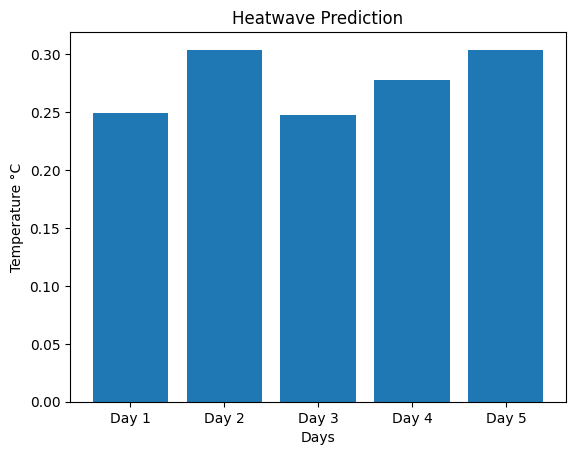

In [74]:
x = np.array(["Day 1","Day 2","Day 3","Day 4","Day 5"])
y = np.array([0.249293,0.304127,0.247315,0.277841,0.303844])
plt.bar(x,y)
plt.title("Heatwave Prediction")
plt.xlabel("Days")
plt.ylabel("Temperature °C")

In [75]:
n_future = 5
DayWise = []
for i in range(1,n_future+1):
  Day_rmse = mean_squared_error(test_y[:i], pred_y[:i], squared=False)
  DayWise.append(Day_rmse)
  print("Day",i," : ",Day_rmse)

Day 1  :  0.05460870359579467
Day 2  :  0.03945837174646579
Day 3  :  0.04829693765514016
Day 4  :  0.04394049072209217
Day 5  :  0.04082187118460118


In [76]:
Five_Days_rmse = mean_squared_error(test_y[:5], pred_y[:5], squared=False)
Five_Days_rmse

0.04082187118460118

Text(0, 0.5, 'Root Mean Square Error')

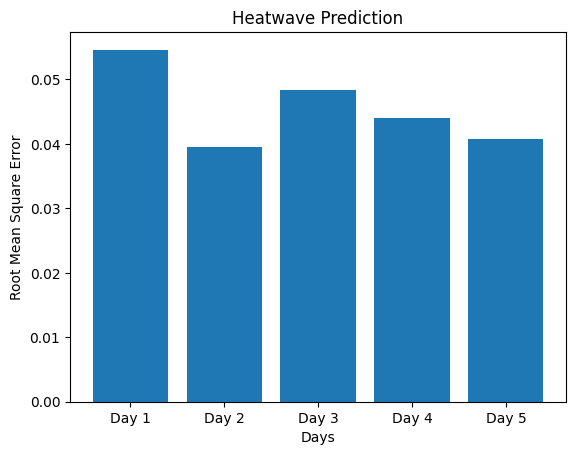

In [77]:
x = np.array(["Day 1","Day 2","Day 3","Day 4","Day 5"])
y = np.array(DayWise)
plt.bar(x,y)
plt.title("Heatwave Prediction")
plt.xlabel("Days")
plt.ylabel("Root Mean Square Error")

In [79]:
np.sum(DayWise)/5

0.045425274980818796